# Validation Comparison for AT & MK Clean OSM, Raw OSM against ENTSOE data

This notebook aims to investigate discrepancies found in osm-data using AT and MK files.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import json
from shapely import wkt
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option("display.max_columns", 1000)

import warnings
warnings.filterwarnings('ignore')

Download the resources that is needed to run this notebook from the following links
- `https://drive.google.com/drive/folders/1zKlh_FKYZlWk0RAQQlhzUdosXa3j-XVN?usp=drive_link`
- `https://drive.google.com/drive/folders/1xOI-0XEixYJvTwP0Hej4q3V-nEKbmKK3?usp=drive_link`

In [2]:
# folder directory for at and mk

at_path = "at_resources"
mk_path = "mk_resources"

In [3]:
# load clean, raw and country files for at and mk with geopandas

at_osm_clean_lines = gpd.read_file(f"{at_path}/osm/clean/all_clean_lines.geojson")
at_osm_raw_lines = gpd.read_file(f"{at_path}/osm/raw/all_raw_lines.geojson")
at_country_shape = gpd.read_file(f"{at_path}/shapes/country_shapes.geojson")

mk_osm_clean_lines = gpd.read_file(f"{mk_path}/osm/clean/all_clean_lines.geojson")
mk_osm_raw_lines = gpd.read_file(f"{mk_path}/osm/raw/all_raw_lines.geojson")
mk_country_shape = gpd.read_file(f"{mk_path}/shapes/country_shapes.geojson")

In [4]:
# load entsoe line.csv with pandas dataframe
entsoe_ref_df = pd.read_csv("entsoe_lines_ref.csv", delimiter=",", quotechar="'")

# apply well known text(wkt) to format the geometry column properly
entsoe_ref_df["geometry"] = entsoe_ref_df.geometry.apply(wkt.loads)

# load the data into a geopandas dataframe and format it using a compatible crs
entsoe_ref = gpd.GeoDataFrame(entsoe_ref_df, geometry="geometry", crs="EPSG:4326")

# convert voltage from kV to V
entsoe_ref["voltage"] = entsoe_ref.voltage * 1000

In [5]:
def if_country_in_entsoe(country_df: gpd.GeoDataFrame) -> pd.Series:
    """
    Function checks if country_df is present in enstoe data
    """
    x = entsoe_ref["geometry"].apply(lambda row: row.within(country_df["geometry"][0]))
    return x


def split_col(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Function to split column by ; and explode the values 
    """
    if type(df[col][0]) == str:
        df[col] = df[col].str.split(";")
        df = df.explode(col)

    return df
    
def preprocess_raw_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function to split col, 
    filter data, 
    replace nan values, 
    convert voltage column to integer, 
    and rename columns
    """

    if "tags.voltage" in df.columns.tolist():
        df = df.rename(columns={"tags.voltage": "voltage", "Length": "length"})

    df = split_col(df, 'voltage')
    df = df[df['voltage'] != 'low']
    df['voltage'] = df['voltage'].replace(np.nan, 0)
    df['voltage'] = df['voltage'].astype(int)

    return df

def high_voltage_df(df: pd.DataFrame, data_col: str, country_code: str) -> pd.DataFrame :
    """
    Function takes dataframe and data_col to distinguish the data.
    it creates a new dataframe by filtering for high voltage and grouping by sum of length
    """

    # if data is at
    if country_code.lower() == f'at':
        # check if it is entsoe data before applying filter
        if 'if_at' in df.columns.tolist():
            df = (df[(df["if_at"] == True) & (
                df['voltage'] >= 220000)][["voltage", "length"]]
                    .groupby(["voltage"])["length"]
                    .sum()
                    .reset_index())

        else:
            df = (df[df["voltage"] >= 220000][["voltage", "length"]]
                    .groupby(["voltage"])["length"]
                    .sum()
                    .reset_index()
                    )
    # if data is mk
    elif country_code.lower() == 'mk':
        # check if it is entsoe data before applying filter
        if 'if_mk' in df.columns.tolist():
            df = (df[(df["if_mk"] == True) & (
                df['voltage'] >= 220000)][["voltage", "length"]]
                    .groupby(["voltage"])["length"]
                    .sum()
                    .reset_index())

        else:
            df = (df[df["voltage"] >= 220000][["voltage", "length"]]
                    .groupby(["voltage"])["length"]
                    .sum()
                    .reset_index()
                    )
            

    # create new column with col_name
    df['data'] = data_col

    return df

def create_plot(df: pd.DataFrame, country: str) -> None:
    """
    Function creates a comparison plot for osm_clean, osm_raw and entsoe data
    country: will be used to identify the country plot
    """ 

    plt.figure(figsize=(15, 5))
    sns.barplot(x="voltage", y="length", hue="data", data=df)
    plt.xlabel("voltage(v)")
    plt.ylabel("length(km)")
    plt.title(
        f"Comparison of the osm_raw, osm_clean and entsoe data in High Voltages for {country.upper()}"
    )
    plt.legend(title="Data", loc="upper right")
    plt.show()

    return None


In [6]:
entsoe_ref["if_at"] = if_country_in_entsoe(at_country_shape)
entsoe_ref["if_mk"] = if_country_in_entsoe(mk_country_shape)

In [7]:
at_osm_raw_lines = preprocess_raw_data(at_osm_raw_lines)
mk_osm_raw_lines = preprocess_raw_data(mk_osm_raw_lines)

In [8]:
"EPSG:4326"

'EPSG:4326'

In [9]:
entsoe_ref['voltage'].replace(400000, 380000, inplace=True)
at_osm_clean_lines['voltage'].replace(400000, 380000, inplace=True)
at_osm_raw_lines['voltage'].replace(400000, 380000, inplace=True)

mk_osm_clean_lines['voltage'].replace(400000, 380000, inplace=True)
mk_osm_raw_lines['voltage'].replace(400000, 380000, inplace=True)

at_osm_clean_lines = at_osm_clean_lines[at_osm_clean_lines['voltage'] != 300000]

In [10]:
df_at_osm_clean_lines = high_voltage_df(at_osm_clean_lines, 'osm_clean', 'at')
df_at_osm_raw_lines = high_voltage_df(at_osm_raw_lines, 'osm_raw', 'at')
df_at_entsoe_lines = high_voltage_df(entsoe_ref, 'entsoe_ref', 'at')

df_mk_osm_clean_lines = high_voltage_df(mk_osm_clean_lines, 'osm_clean', 'mk')
df_mk_osm_raw_lines = high_voltage_df(mk_osm_raw_lines, 'osm_raw', 'mk')
df_mk_entsoe_lines = high_voltage_df(entsoe_ref, 'entsoe_ref', 'mk')

In [11]:
# merge osm_clean, osm_raw and entsoe preprocess data into a single dataframe for AT
at_dataframe = pd.concat([
    df_at_osm_raw_lines, 
    df_at_osm_clean_lines, 
    df_at_entsoe_lines], ignore_index=True
    )
    
# merge osm_clean, osm_raw and entsoe preprocess data into a single dataframe for MK
mk_dataframe = pd.concat([
    df_mk_osm_raw_lines, 
    df_mk_osm_clean_lines, 
    df_mk_entsoe_lines], ignore_index=True
)

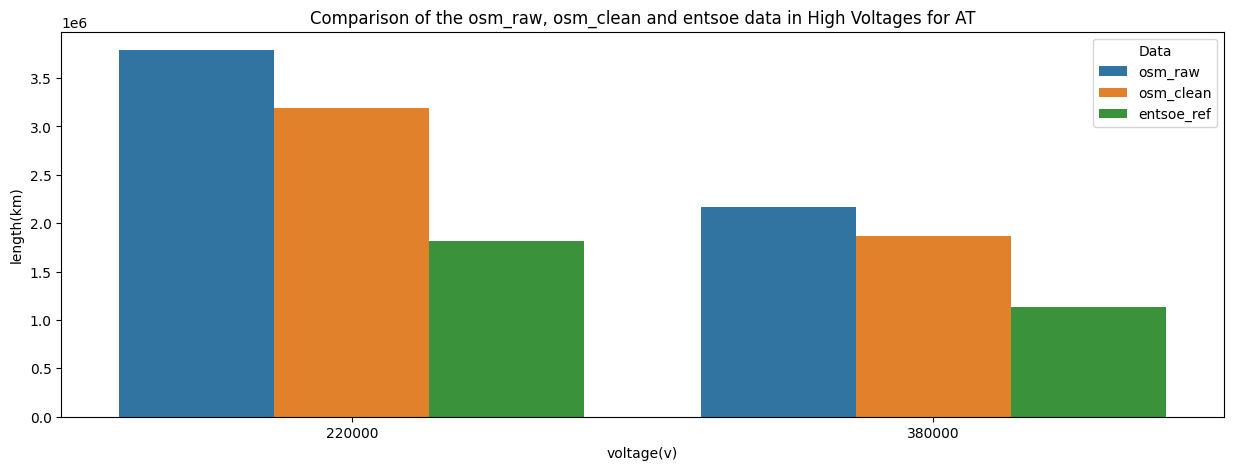

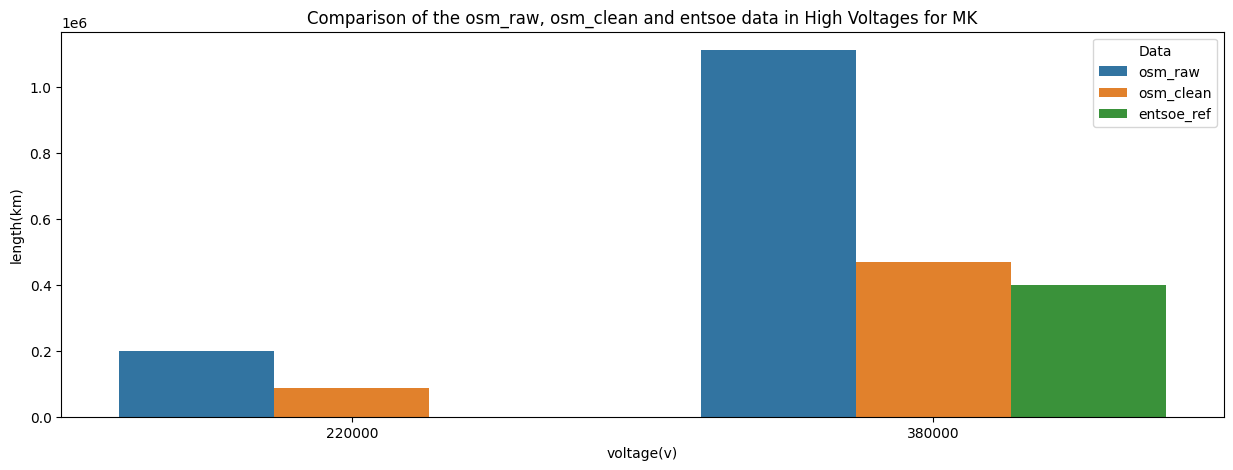

In [12]:
create_plot(at_dataframe, 'at')
create_plot(mk_dataframe, 'mk')

### Table representing sum of length for different voltage levels

In [13]:
at_dataframe.pivot(index='voltage', columns='data', values='length')

data,entsoe_ref,osm_clean,osm_raw
voltage,,,
220000,1.812981e+06,3.192921e+06,3.789003e+06
380000,1.138607e+06,1.865833e+06,2.169454e+06


In [14]:
mk_dataframe.pivot(index='voltage', columns='data', values='length')

data,entsoe_ref,osm_clean,osm_raw
voltage,,,
220000,NaN,87942.816924,1.998913e+05
380000,401388.572228,469160.594075,1.113347e+06


### Geospatial Visualization

In [15]:
def geospatial_plot(voltage_level: int):
    """
    Function takes voltage level and plot a geospatial plot based on the voltage_level
    """
    
    ax_mk = mk_country_shape.plot(edgecolor='grey', alpha=.5, figsize=(15,10),cmap='OrRd')
    # ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326',zoom='auto', alpha=0.5)

    mk_osm_raw_lines[mk_osm_raw_lines['voltage'] == voltage_level].plot(figsize=(15,10), color="red", alpha=0.2, ax=ax_mk, label='raw')
    mk_osm_clean_lines[mk_osm_clean_lines['voltage'] == voltage_level].plot(figsize=(15,10), color="blue", alpha=0.6, ax=ax_mk, label='clean')

    # to handle empty values in entsoe data in voltage level 220000 in MK data
    if len(entsoe_ref[(entsoe_ref['if_mk'] == True) & (entsoe_ref['voltage'] == voltage_level)]) is not 0:
        entsoe_ref[(entsoe_ref['if_mk'] == True) & (entsoe_ref['voltage'] == voltage_level)].plot(figsize=(15,10), color='green', alpha=1.0, ax=ax_mk, label='entsoe')
   
    plt.title(f"Comparison of the osm_raw, osm_clean and entsoe data in High Voltages for MK ({voltage_level}V)")
    plt.xlabel("longtitude")
    plt.ylabel("latitude")
    plt.legend()
    plt.show()

    ax_at = at_country_shape.plot(edgecolor='grey', alpha=.5, figsize=(15,10),cmap='OrRd')
    # ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326',zoom='auto', alpha=0.5)

    at_osm_raw_lines[at_osm_raw_lines['voltage'] == voltage_level].plot(figsize=(15,10), color="red", alpha=0.3, ax=ax_at, label='raw')
    at_osm_clean_lines[at_osm_clean_lines['voltage'] == voltage_level].plot(figsize=(15,10), color="blue", alpha=0.6, ax=ax_at, label='clean')
    entsoe_ref[(entsoe_ref['if_at'] == True) & (entsoe_ref['voltage'] == voltage_level)].plot(figsize=(15,10), color='green', alpha=1.0, ax=ax_at, label='entsoe')

    plt.title(f"Comparison of the osm_raw, osm_clean and entsoe data in High Voltages for AT ({voltage_level}V)")
    plt.xlabel("longtitude")
    plt.ylabel("latitude")
    plt.legend()

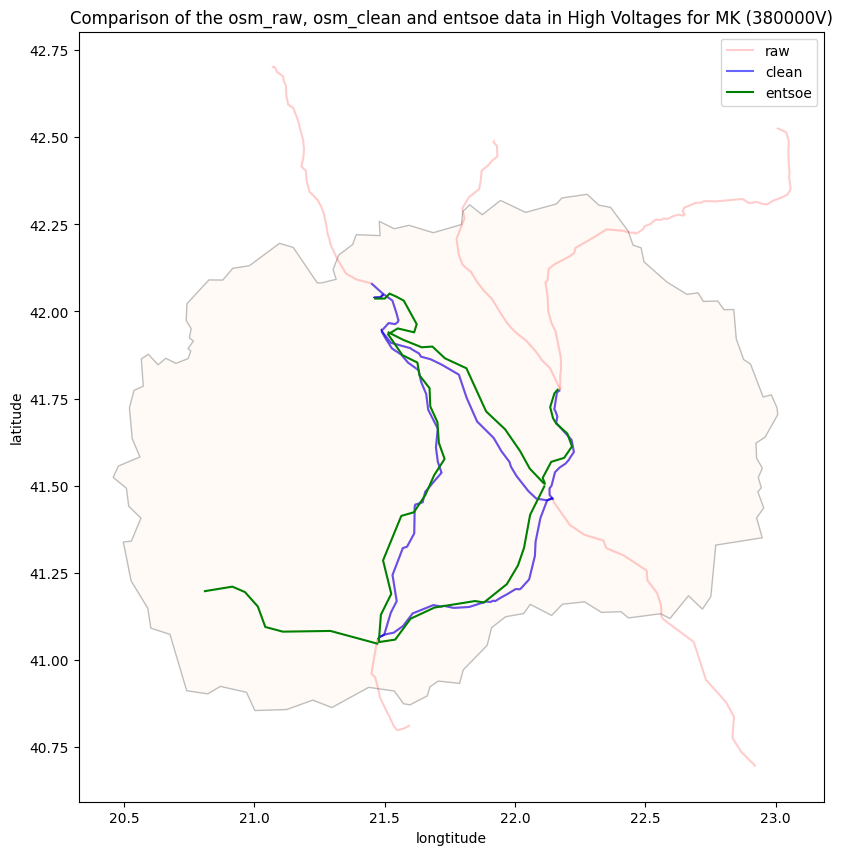

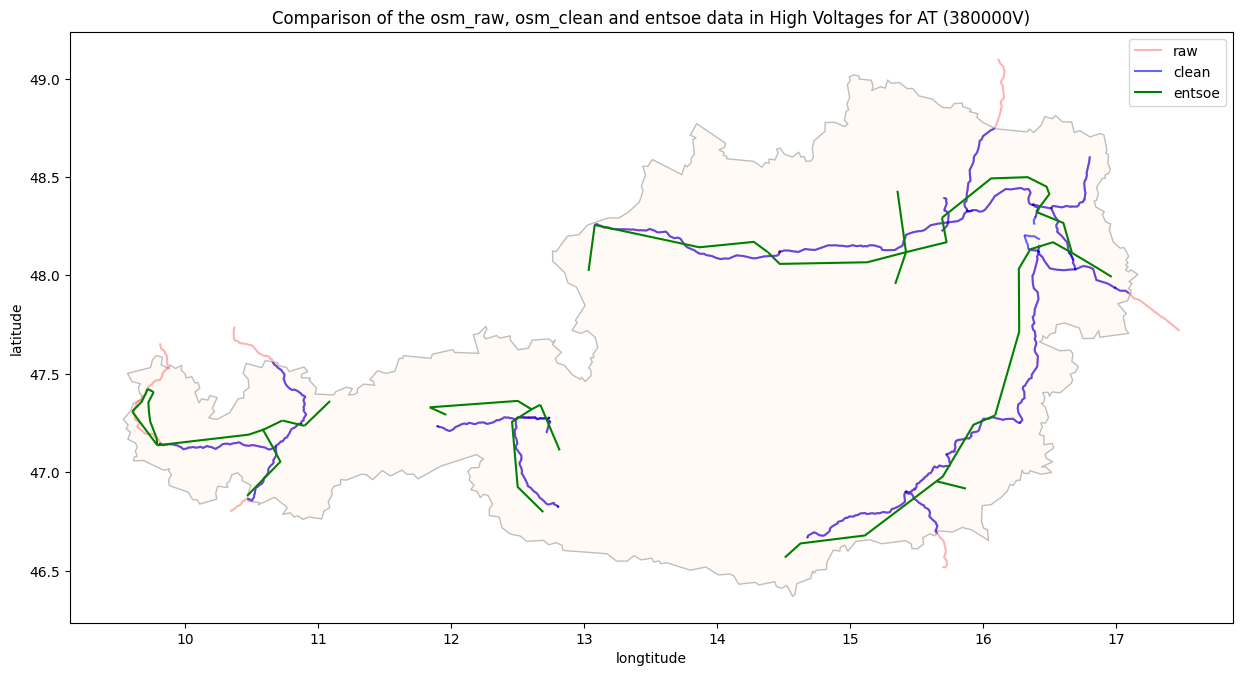

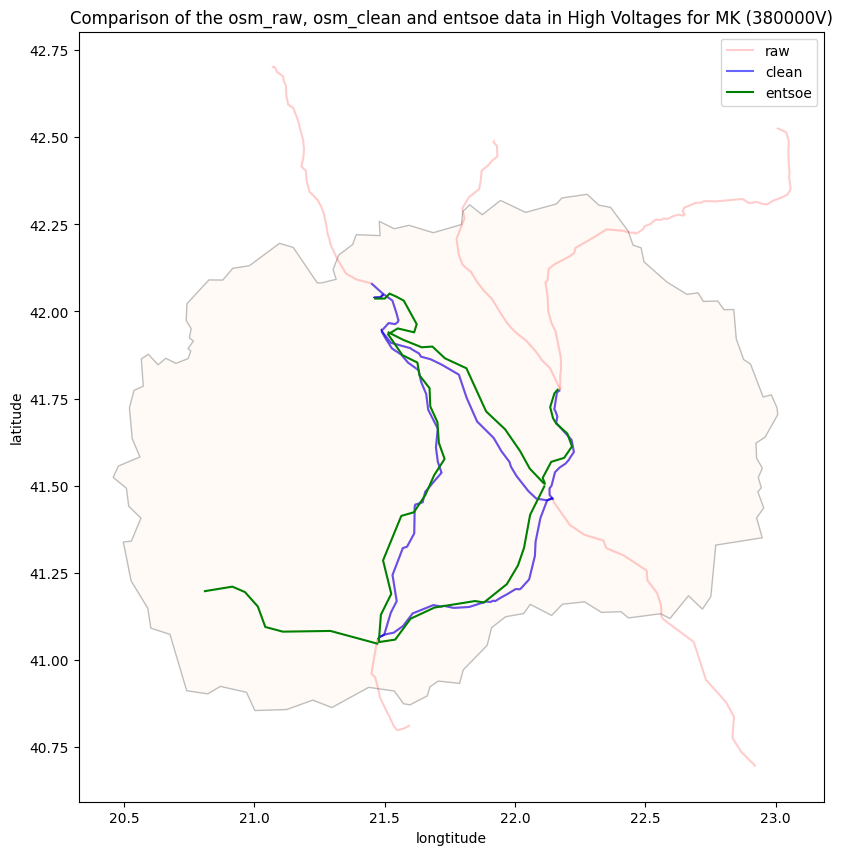

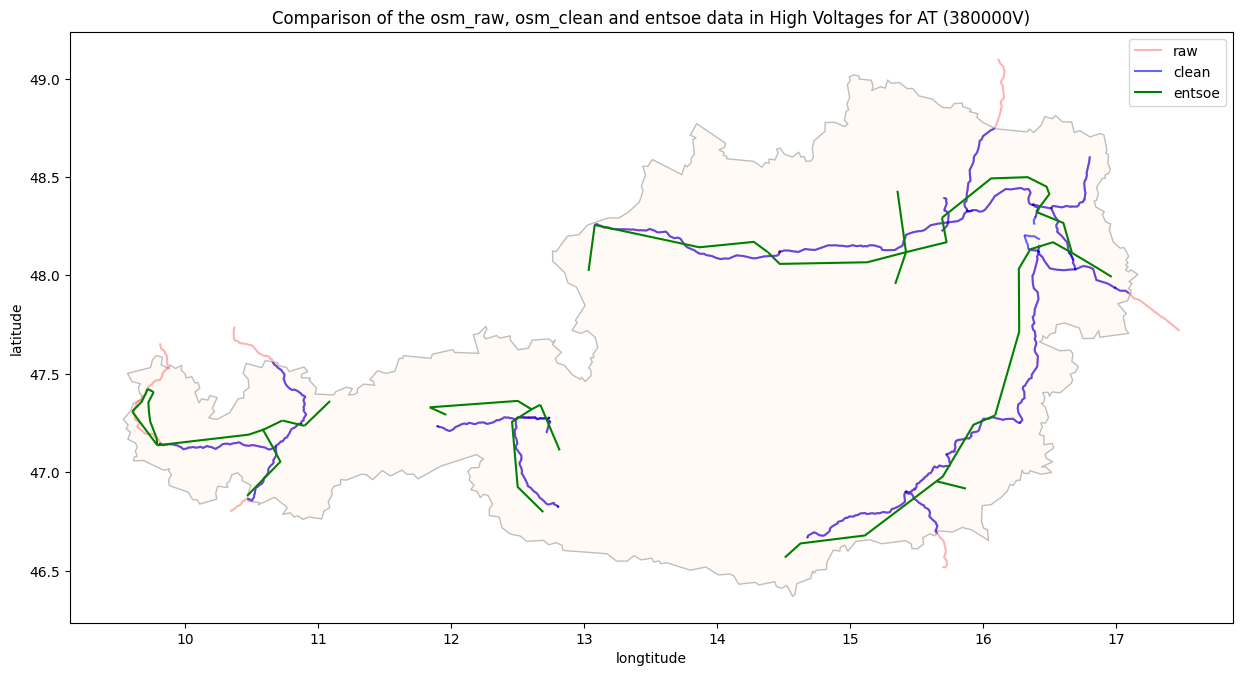

In [16]:
geospatial_plot(380000)
geospatial_plot(380000)

## Section 2 Applying Simplification

In [17]:
at_osm_clean_lines_copy = at_osm_clean_lines.copy()
at_osm_raw_lines_copy = at_osm_raw_lines.copy()

mk_osm_clean_lines_copy = mk_osm_clean_lines.copy()
mk_osm_raw_lines_copy = mk_osm_raw_lines.copy()

In [18]:
simplification_tolerance = 0.05

at_osm_clean_lines_copy.geometry = at_osm_clean_lines_copy.geometry.simplify(simplification_tolerance)
at_osm_raw_lines_copy.geometry = at_osm_raw_lines_copy.geometry.simplify(simplification_tolerance)

mk_osm_clean_lines_copy.geometry = mk_osm_clean_lines_copy.geometry.simplify(simplification_tolerance)
mk_osm_raw_lines_copy.geometry = mk_osm_raw_lines_copy.geometry.simplify(simplification_tolerance)

In [19]:
at_osm_clean_lines_copy['length'] = at_osm_clean_lines_copy.to_crs(epsg=3857).length
at_osm_raw_lines_copy['length'] = at_osm_raw_lines_copy.to_crs(epsg=3857).length

mk_osm_clean_lines_copy['length'] = mk_osm_clean_lines_copy.to_crs(epsg=3857).length
mk_osm_raw_lines_copy['length'] = mk_osm_raw_lines_copy.to_crs(epsg=3857).length

In [20]:
df_at_osm_clean_lines_copy = high_voltage_df(at_osm_clean_lines_copy, 'osm_clean', 'at')
df_at_osm_raw_lines_copy = high_voltage_df(at_osm_raw_lines_copy, 'osm_raw', 'at')
# df_at_entsoe_lines_copy = high_voltage_df(entsoe_ref, 'entsoe_ref', 'at')

df_mk_osm_clean_lines_copy = high_voltage_df(mk_osm_clean_lines_copy, 'osm_clean', 'mk')
df_mk_osm_raw_lines_copy = high_voltage_df(mk_osm_raw_lines_copy, 'osm_raw', 'mk')
# df_mk_entsoe_lines_copy = high_voltage_df(entsoe_ref, 'entsoe_ref', 'mk')

In [21]:
# merge osm_clean, osm_raw and entsoe preprocess data into a single dataframe for AT
at_dataframe_copy = pd.concat([
    df_at_osm_raw_lines_copy, 
    df_at_osm_clean_lines_copy, 
    df_at_entsoe_lines], ignore_index=True
    )
    
# merge osm_clean, osm_raw and entsoe preprocess data into a single dataframe for MK
mk_dataframe_copy = pd.concat([
    df_mk_osm_raw_lines_copy, 
    df_mk_osm_clean_lines_copy, 
    df_mk_entsoe_lines], ignore_index=True
)

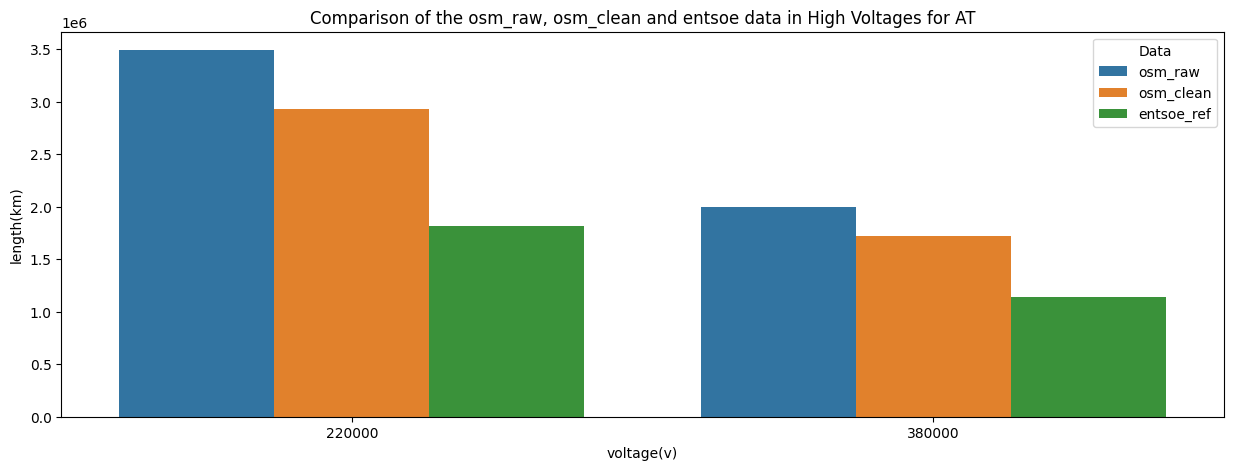

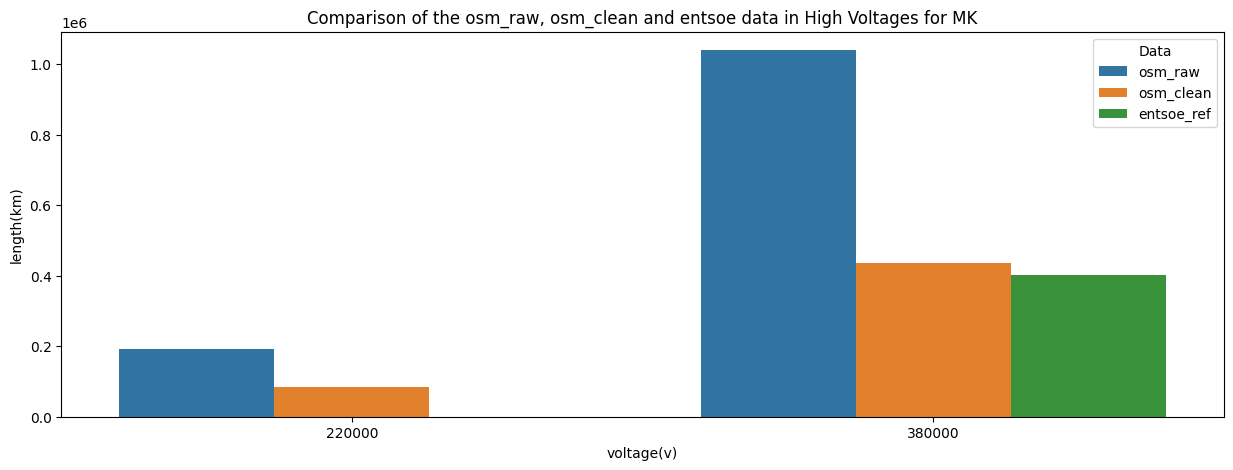

In [22]:
create_plot(at_dataframe_copy, 'at')
create_plot(mk_dataframe_copy, 'mk')

In [23]:
at_dataframe_copy.pivot(index='voltage', columns='data', values='length')

data,entsoe_ref,osm_clean,osm_raw
voltage,,,
220000,1.812981e+06,2.933003e+06,3.493597e+06
380000,1.138607e+06,1.724096e+06,2.002452e+06


In [24]:
mk_dataframe_copy.pivot(index='voltage', columns='data', values='length')

data,entsoe_ref,osm_clean,osm_raw
voltage,,,
220000,NaN,84720.853537,1.908065e+05
380000,401388.572228,434829.126876,1.040079e+06


In [25]:
def geospatial_plot_simplified(voltage_level: int):
    """
    Function takes voltage level and plot a geospatial plot based on the voltage_level for simplified data
    """
    
    ax_mk = mk_country_shape.plot(edgecolor='grey', alpha=.5, figsize=(15,10),cmap='OrRd')
    # ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326',zoom='auto', alpha=0.5)

    mk_osm_raw_lines_copy[mk_osm_raw_lines_copy['voltage'] == voltage_level].plot(figsize=(15,10), color="red", alpha=0.2, ax=ax_mk, label='raw')
    mk_osm_clean_lines_copy[mk_osm_clean_lines_copy['voltage'] == voltage_level].plot(figsize=(15,10), color="blue", alpha=0.6, ax=ax_mk, label='clean')

    # to handle empty values in entsoe data in voltage level 220000 in MK data
    if len(entsoe_ref[(entsoe_ref['if_mk'] == True) & (entsoe_ref['voltage'] == voltage_level)]) is not 0:
        entsoe_ref[(entsoe_ref['if_mk'] == True) & (entsoe_ref['voltage'] == voltage_level)].plot(figsize=(15,10), color='green', alpha=1.0, ax=ax_mk, label='entsoe')
    
    plt.title(f"Comparison of the osm_raw, osm_clean and entsoe data in High Voltages for MK ({voltage_level}V) after simplification")
    plt.xlabel("longtitude")
    plt.ylabel("latitude")
    plt.legend()
    plt.show()

    ax_at = at_country_shape.plot(edgecolor='grey', alpha=.5, figsize=(15,10),cmap='OrRd')
    # ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326',zoom='auto', alpha=0.5)

    at_osm_raw_lines_copy[at_osm_raw_lines_copy['voltage'] == voltage_level].plot(figsize=(15,10), color="red", alpha=0.3, ax=ax_at, label='raw')
    at_osm_clean_lines_copy[at_osm_clean_lines_copy['voltage'] == voltage_level].plot(figsize=(15,10), color="blue", alpha=0.6, ax=ax_at, label='clean')
    entsoe_ref[(entsoe_ref['if_at'] == True) & (entsoe_ref['voltage'] == voltage_level)].plot(figsize=(15,10), color='green', alpha=1.0, ax=ax_at, label='entsoe')

    plt.title(f"Comparison of the osm_raw, osm_clean and entsoe data in High Voltages for AT ({voltage_level}V) after simplification")
    plt.xlabel("longtitude")
    plt.ylabel("latitude")
    plt.legend()

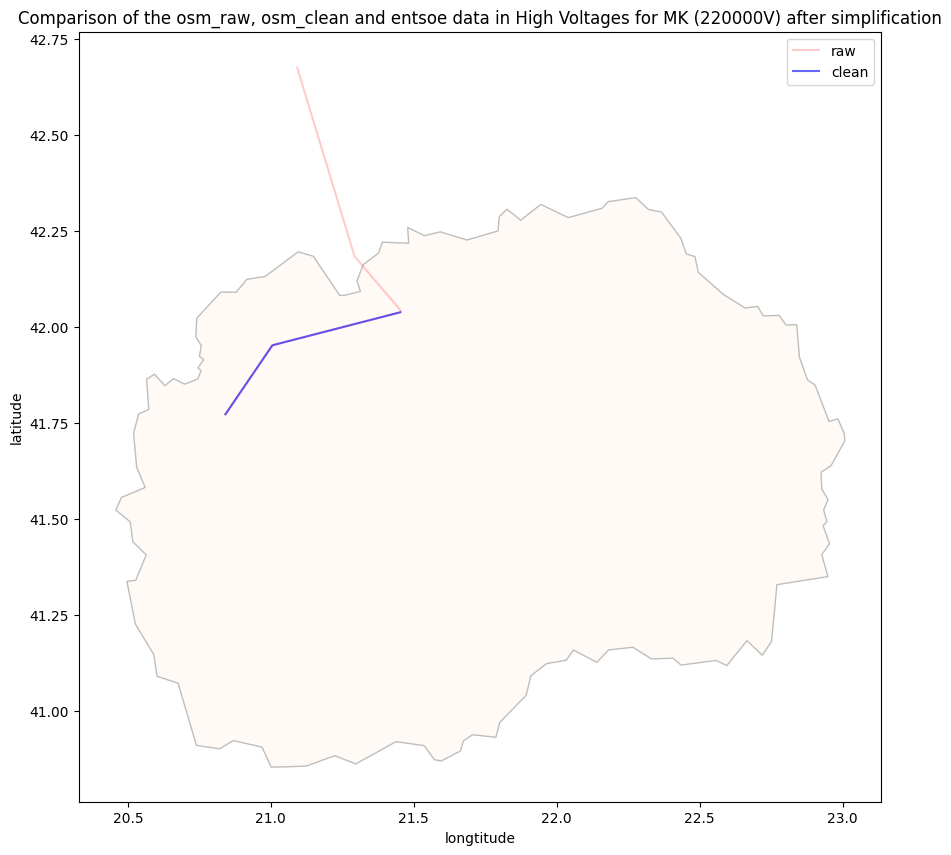

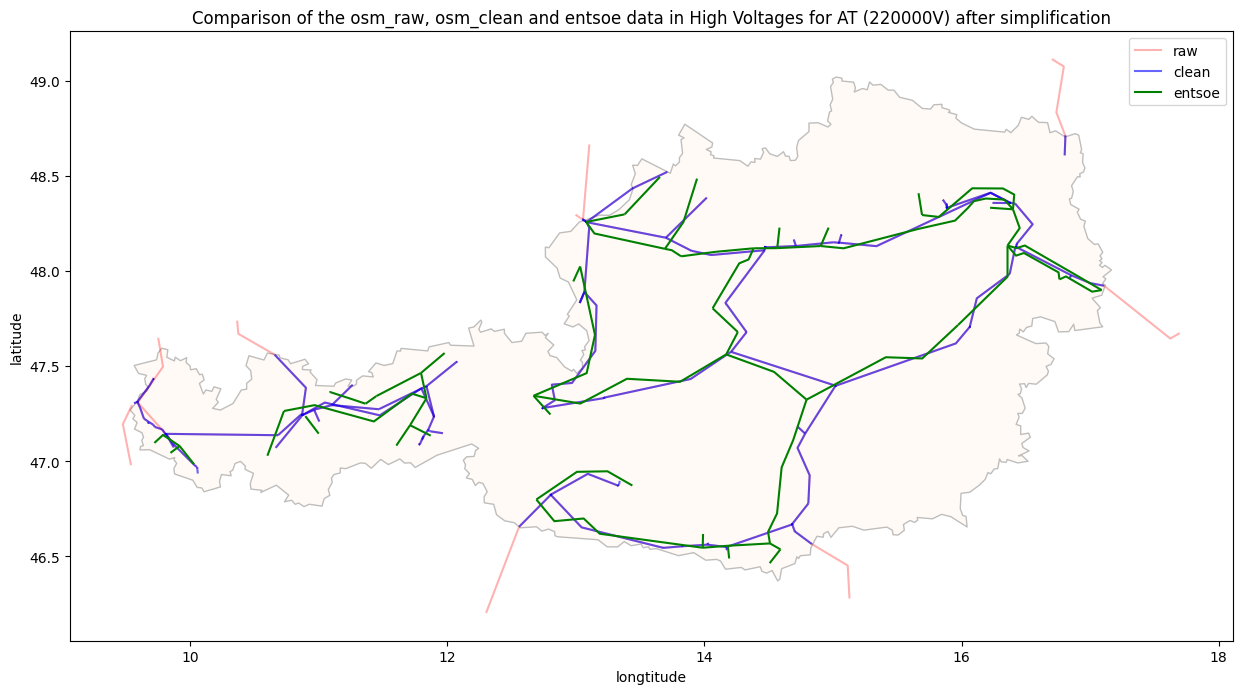

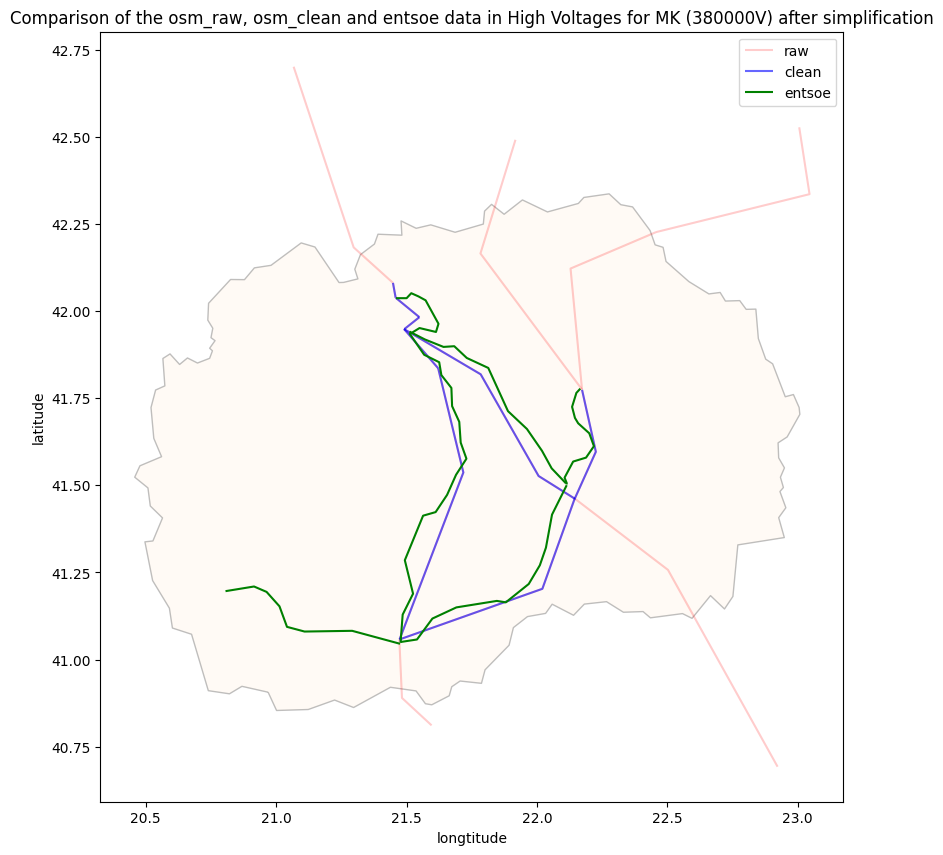

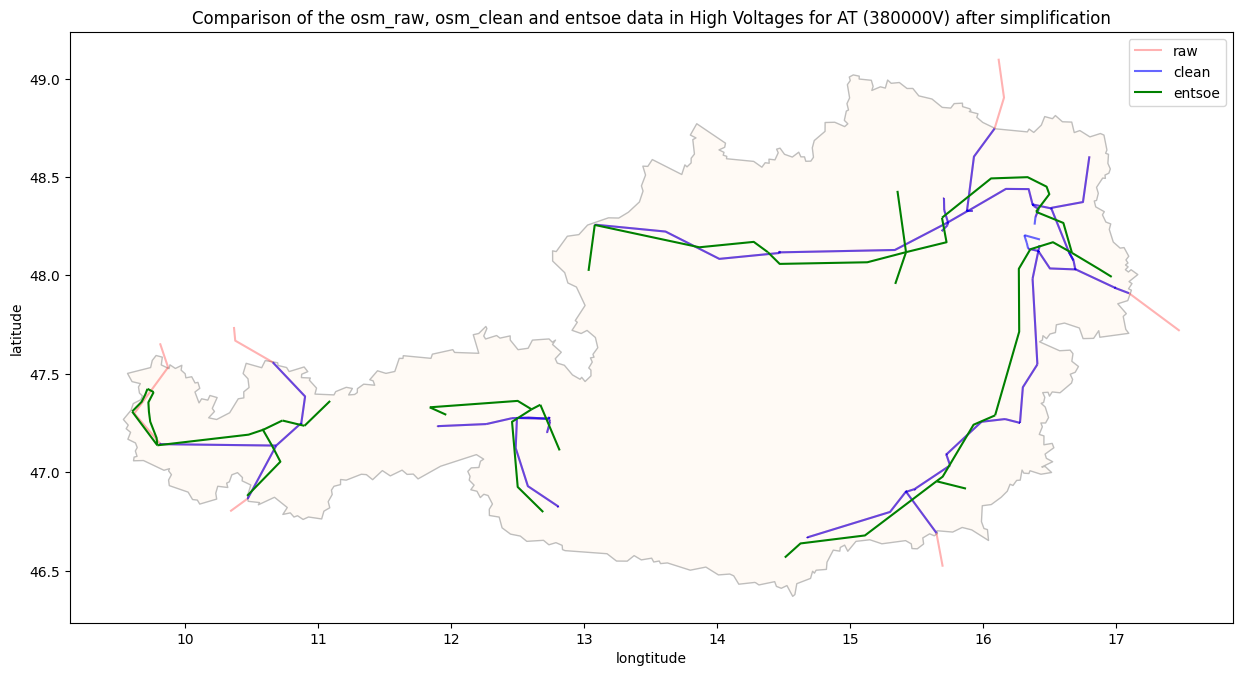

In [26]:
geospatial_plot_simplified(220000)
geospatial_plot_simplified(380000)

## Simplified vs Non Simplified

In [27]:
def percentage_difference(df: pd.DataFrame, df_copy: pd.DataFrame) -> pd.DataFrame:
    """
    Function takes two dataframe and return the percentage between the dataframes
    """
    numerator = (df.pivot(index='voltage', columns='data', values='length') - df_copy.pivot(index='voltage', columns='data', values='length'))
    denominator = (df_copy.pivot(index='voltage', columns='data', values='length')) * 100
    return numerator/denominator

def simplified_plot(df: pd.DataFrame, country_code: str) -> None:
    """
    Functions plots a comparison plot between simplified data and non_simplified data for osm and entsoe
    """
    plt.figure(figsize=(15, 5))
    sns.barplot(x="voltage", y="length", hue="data", data=df, palette='Set1')

    plt.xlabel("voltage(v)")
    plt.ylabel("length(km)")
    plt.title(
        f"Comparison of the osm_raw, osm_clean and entsoe data in High Voltages for {country_code.upper()}"
    )
    plt.legend(title="Data", loc="upper right")
    plt.show()

    return None

In [28]:
# percentage difference for MK
percentage_difference(mk_dataframe, mk_dataframe_copy)

data,entsoe_ref,osm_clean,osm_raw
voltage,,,
220000,NaN,0.00038,0.000476
380000,0.0,0.00079,0.000704


In [29]:
# percentage difference for AT
percentage_difference(at_dataframe, at_dataframe_copy)

data,entsoe_ref,osm_clean,osm_raw
voltage,,,
220000,0.0,0.000886,0.000846
380000,0.0,0.000822,0.000834


In [30]:
# replacing the columns names before concatenating with the original dataframe

at_dataframe_copy = at_dataframe_copy.replace(
    {"osm_raw": "osm_raw_sim", "osm_clean": "osm_clean_sim"})
mk_dataframe_copy = mk_dataframe_copy.replace(
    {"osm_raw": "osm_raw_sim", "osm_clean": "osm_clean_sim"})


In [31]:
# concat the original dataframe with the simplified dataframe

df_at = pd.concat([at_dataframe, at_dataframe_copy])
df_at = df_at.sort_values(['length','data'], ascending=False)

df_mk = pd.concat([mk_dataframe, mk_dataframe_copy])
df_mk = df_mk.sort_values(['length','data'], ascending=False)

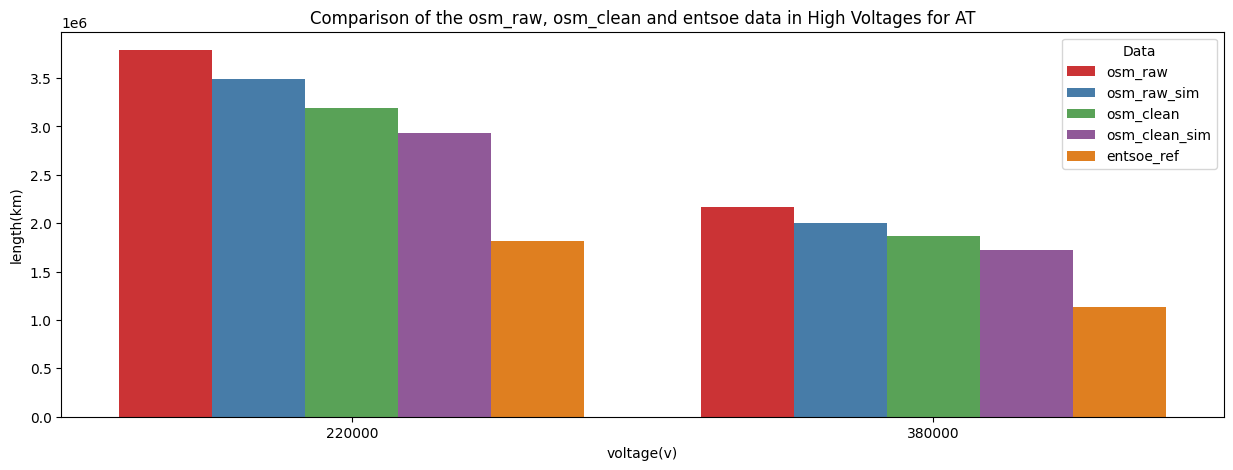

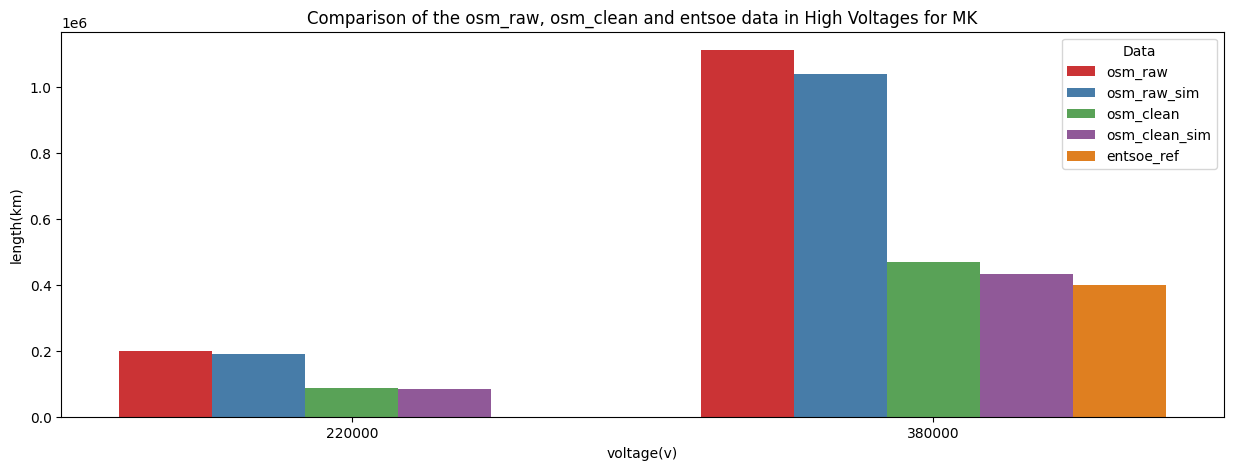

In [32]:
simplified_plot(df_at, 'at')
simplified_plot(df_mk, 'mk')

# Conclusion

From the analysis, it is observed that osm-data is more accurate compared to entsoe-data. osm-data uses lower simplification compared to entsoe-data which makes it more accurate. 